In [1]:
import pandas as pd
from tensorflow.keras.preprocessing import image

import tensorflow as tf

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet152V2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import activations
from tqdm import tqdm
import numpy as np

In [37]:
df = pd.read_csv('./data/HAM10000_Metadata')

(Warning for Sunlight, increased risk of cancer) Actinic keratoses and intraepithelial carcinoma / Bowen's disease (__akiec__), 0

(Skin cancer) basal cell carcinoma (__bcc__), 1

(HARMLESS) benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, __bkl__), 2

(HARMLESS) dermatofibroma (__df__),  3

melanoma (__mel__),  4

(Not entirely harmless) melanocytic nevi (__nv__)   5

(HARMLESS) vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, __vasc__). 6 


More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesion_id-column within the HAM10000_metadata file.

In [23]:
# Number of cases where we can use LSTM

(df['lesion_id'].value_counts() > 1).sum()

1956

In [3]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [11]:
df = df.sample(frac = 1).reset_index()

df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,risk
0,6790,HAM_0004318,ISIC_0031678,nv,histo,45.0,female,back,vidir_modern,1.0
1,3921,HAM_0004015,ISIC_0027892,nv,follow_up,50.0,female,lower extremity,vidir_molemax,1.0
2,7038,HAM_0003892,ISIC_0028045,nv,histo,25.0,female,lower extremity,vidir_modern,1.0
3,3017,HAM_0002877,ISIC_0030435,nv,follow_up,50.0,male,trunk,vidir_molemax,1.0
4,9722,HAM_0004012,ISIC_0025831,akiec,histo,65.0,female,face,rosendahl,2.0


In [5]:
df['localization'].unique()

array(['back', 'chest', 'trunk', 'unknown', 'abdomen', 'upper extremity',
       'foot', 'lower extremity', 'ear', 'face', 'neck', 'scalp',
       'genital', 'hand', 'acral'], dtype=object)

In [6]:
temp = []

for i in range(0, 10015):
    loc = df.iloc[i]['localization']
    if loc == 'abdomen':
        temp.append(tf.one_hot(0, 15))
    elif loc == 'scalp':
        temp.append(tf.one_hot(1, 15))
    elif loc == 'lower extremity':
        temp.append(tf.one_hot(2, 15))
    elif loc == 'trunk':
        temp.append(tf.one_hot(3, 15))
    elif loc == 'upper extremity':
        temp.append(tf.one_hot(4, 15))
    elif loc == 'back':
        temp.append(tf.one_hot(5, 15))
    elif loc == 'neck':
        temp.append(tf.one_hot(6, 15))
    elif loc == 'face':
        temp.append(tf.one_hot(7, 15))
    elif loc == 'chest':
        temp.append(tf.one_hot(8, 15))
    elif loc == 'foot':
        temp.append(tf.one_hot(9, 15))
    elif loc == 'ear':
        temp.append(tf.one_hot(10, 15))
    elif loc == 'unknown':
        temp.append(tf.one_hot(11, 15))
    elif loc == 'hand':
        temp.append(tf.one_hot(12, 15))
    elif loc == 'acral':
        temp.append(tf.one_hot(13, 15))
    elif loc == 'genital':
        temp.append(tf.one_hot(14, 15))

In [7]:
one_hot_loc = np.array(temp)

one_hot_loc

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
# VGG-16
preprocessed = []

VGG_load = VGG16(weights='imagenet', include_top=False)
model = models.Sequential()
model.add(VGG_load)
model.add(layers.Flatten())


for i in tqdm(range(0, 10015)):
    file = df.iloc[i]['image_id']
    ohl = one_hot_loc[i]
    
    img = image.load_img('./Data/HAM10000_images/' + file + '.jpg', target_size= (224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    preds = model.predict(img).reshape(25088)

    preprocessed.append(np.concatenate((preds, ohl)))
    
df['VGG16'] = preprocessed

  0%|          | 1/10015 [00:01<3:00:36,  1.08s/it]

(25103,)


  0%|          | 2/10015 [00:02<2:47:07,  1.00s/it]

(25103,)


  0%|          | 3/10015 [00:02<2:40:20,  1.04it/s]

(25103,)


  0%|          | 4/10015 [00:03<2:37:02,  1.06it/s]

(25103,)


  0%|          | 5/10015 [00:04<2:35:18,  1.07it/s]

(25103,)


  0%|          | 6/10015 [00:05<2:34:05,  1.08it/s]

(25103,)


  0%|          | 7/10015 [00:06<2:33:19,  1.09it/s]

(25103,)


  0%|          | 8/10015 [00:07<2:32:51,  1.09it/s]

(25103,)


  0%|          | 9/10015 [00:08<2:33:02,  1.09it/s]

(25103,)


  0%|          | 10/10015 [00:09<2:32:35,  1.09it/s]

(25103,)


  0%|          | 11/10015 [00:10<2:32:22,  1.09it/s]

(25103,)


  0%|          | 12/10015 [00:11<2:32:29,  1.09it/s]

(25103,)


  0%|          | 13/10015 [00:12<2:34:34,  1.08it/s]

(25103,)


  0%|          | 13/10015 [00:13<2:47:14,  1.00s/it]


KeyboardInterrupt: 

In [12]:
# Inception
preprocessed = []

IV3_load = InceptionV3(weights='imagenet', include_top=False)
model = models.Sequential()
model.add(IV3_load)
model.add(layers.Flatten())

for i in tqdm(range(0, 10015)):
    file = df.iloc[i]['image_id']
    ohl = one_hot_loc[i]
    
    img = image.load_img('./Data/HAM10000_images/' + file + '.jpg', target_size= (299,299))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    preds = model.predict(img).reshape(131072)

    preprocessed.append(np.concatenate((preds, ohl)))
    
df['IV3'] = preprocessed

  0%|          | 15/10015 [00:10<1:56:39,  1.43it/s]


KeyboardInterrupt: 

In [14]:
# ResNet
preprocessed = []

resnet_load = ResNet152V2(weights='imagenet', include_top=False)
model = models.Sequential()
model.add(resnet_load)
model.add(layers.Flatten())


for i in tqdm(range(0, 10015)):
    file = df.iloc[i]['image_id']
    ohl = one_hot_loc[i]    
    
    img = image.load_img('./Data/HAM10000_images/' + file + '.jpg', target_size= (224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.resnet_v2.preprocess_input(img)
    preds = model.predict(img).reshape(100352)

    preprocessed.append(np.concatenate((preds, ohl)))
    
df['resnet'] = preprocessed

  0%|          | 6/10015 [00:13<6:09:56,  2.22s/it] 


KeyboardInterrupt: 

In [15]:
labels = []
for i in range(0, 10015):
    dx = df.iloc[i]['dx']
    if dx == 'akiec':
        labels.append(tf.one_hot(0, 7))
    elif dx == 'bcc':
        labels.append(tf.one_hot(1, 7))
    elif dx == 'bkl':
        labels.append(tf.one_hot(2, 7))
    elif dx == 'df':
        labels.append(tf.one_hot(3, 7))
    elif dx == 'mel':
        labels.append(tf.one_hot(4, 7))
    elif dx == 'nv':
        labels.append(tf.one_hot(5, 7))
    elif dx == 'vasc':
        labels.append(tf.one_hot(6, 7))
        
df['one_hot'] = labels

In [16]:
df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,one_hot
0,8226,HAM_0001212,ISIC_0024846,nv,histo,40.0,female,back,vienna_dias,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T..."
1,2819,HAM_0007557,ISIC_0030964,bcc,histo,55.0,male,back,rosendahl,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T..."
2,8102,HAM_0005232,ISIC_0025993,nv,histo,25.0,female,chest,vienna_dias,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T..."
3,5582,HAM_0003557,ISIC_0026973,nv,follow_up,75.0,male,trunk,vidir_molemax,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T..."
4,8077,HAM_0001136,ISIC_0031848,nv,histo,40.0,male,chest,vienna_dias,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T..."


(Warning for Sunlight, increased risk of cancer) Actinic keratoses and intraepithelial carcinoma / Bowen's disease (__akiec__), 0

(Skin cancer) basal cell carcinoma (__bcc__), 1

(HARMLESS) benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, __bkl__), 2

(HARMLESS) dermatofibroma (__df__),  3

melanoma (__mel__),  4

(Not entirely harmless) melanocytic nevi (__nv__)   5

(HARMLESS) vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, __vasc__). 6 


More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesion_id-column within the HAM10000_metadata file.

In [10]:
risk = []

for i in range(0, 10015):
    if df.iloc[i]['dx'] in ['bkl', 'df', 'vasc']:
        risk.append(0.0)
    elif df.iloc[i]['dx'] == 'nv':
        risk.append(1.0)
    elif df.iloc[i]['dx'] == 'akiec':
        risk.append(2.0)
    elif df.iloc[i]['dx'] in ['mel', 'bcc']:
        risk.append(3.0)
        
df['risk'] = risk

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,risk
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,0.0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,0.0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,0.0
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,0.0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,0.0


In [41]:
df[df['risk'] == 3.0]['dx'].value_counts()

mel    1113
bcc     514
Name: dx, dtype: int64

In [27]:
VGG_X = np.array(df['VGG16'])
IV3_X = np.array(df['IV3'])
RES_X = np.array(df['resnet'])

KeyError: 'VGG16'

In [31]:
#y = np.array(df['one_hot'])

y = np.array(df['risk'])

In [105]:
vgg_model = models.Sequential()
vgg_model.add(layers.Dense(8192, activation='relu'))
vgg_model.add(layers.Dense(4096, activation='relu'))
vgg_model.add(layers.Dense(2048, activation='relu'))
vgg_model.add(layers.Dense(1024, activation='relu'))
vgg_model.add(layers.Dense(512, activation='relu'))
vgg_model.add(layers.Dense(128, activation='relu'))
vgg_model.add(layers.Dense(4))

In [107]:
new_VGG = np.asarray(new_VGG).astype('float32')

In [108]:
new_VGG.shape

(10015, 7, 7, 512)

In [109]:
new_y = []
for ele in y:
    new_y.append(np.array(ele))
    
new_y = np.array(new_y)

new_y.shape

(10015, 7)

In [110]:
model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
model.fit(new_VGG, new_y, epochs=10, validation_split=0.1)

Train on 10015 samples
Epoch 1/10
   96/10015 [..............................] - ETA: 11:09 - loss: 102.7127 - accuracy: 0.6094

KeyboardInterrupt: 

In [114]:
res_model = models.Sequential()
res_model.add(layers.Dense(8192, activation='relu'))
res_model.add(layers.Dense(4096, activation='relu'))
res_model.add(layers.Dense(2048, activation='relu'))
res_model.add(layers.Dense(1024, activation='relu'))
res_model.add(layers.Dense(512, activation='relu'))
res_model.add(layers.Dense(128, activation='relu'))
res_model.add(layers.Dense(4))

In [117]:
res_model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
res_model.fit(new_RES, new_y, epochs=10, validation_split=0.1)

Train on 10015 samples
Epoch 1/10
   32/10015 [..............................] - ETA: 1:34:13

KeyboardInterrupt: 

In [124]:
iv3_model = models.Sequential()
iv3_model.add(layers.Dense(8192, activation='relu'))
iv3_model.add(layers.Dense(4096, activation='relu'))
iv3_model.add(layers.Dense(2048, activation='relu'))
iv3_model.add(layers.Dense(1024, activation='relu'))
iv3_model.add(layers.Dense(512, activation='relu'))
iv3_model.add(layers.Dense(128, activation='relu'))
iv3_model.add(layers.Dense(4))

In [ ]:
iv3_model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
iv3_model.fit(new_IV3, new_y, epochs=10, validation_split=0.1)

Train on 9013 samples, validate on 1002 samples
Epoch 1/10


# New Original Model

In [38]:
df = pd.read_csv('./data/HAM10000_Metadata')

In [39]:
df = df.sample(frac = 1).reset_index()

df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,8821,HAM_0006366,ISIC_0030732,nv,histo,65.0,female,upper extremity,rosendahl
1,7580,HAM_0001026,ISIC_0033743,nv,histo,20.0,female,foot,vidir_modern
2,6473,HAM_0002059,ISIC_0028061,nv,follow_up,40.0,female,trunk,vidir_molemax
3,1553,HAM_0000611,ISIC_0033804,mel,histo,30.0,female,back,vidir_modern
4,8823,HAM_0002025,ISIC_0025169,nv,histo,5.0,male,scalp,rosendahl


In [40]:
risk = []

for i in range(0, 10015):
    if df.iloc[i]['dx'] in ['bkl', 'df', 'vasc']:
        risk.append(0.0)
    elif df.iloc[i]['dx'] == 'nv':
        risk.append(1.0)
    elif df.iloc[i]['dx'] == 'akiec':
        risk.append(2.0)
    elif df.iloc[i]['dx'] in ['mel', 'bcc']:
        risk.append(3.0)
        
df['risk'] = risk

df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,risk
0,8821,HAM_0006366,ISIC_0030732,nv,histo,65.0,female,upper extremity,rosendahl,1.0
1,7580,HAM_0001026,ISIC_0033743,nv,histo,20.0,female,foot,vidir_modern,1.0
2,6473,HAM_0002059,ISIC_0028061,nv,follow_up,40.0,female,trunk,vidir_molemax,1.0
3,1553,HAM_0000611,ISIC_0033804,mel,histo,30.0,female,back,vidir_modern,3.0
4,8823,HAM_0002025,ISIC_0025169,nv,histo,5.0,male,scalp,rosendahl,1.0


In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'risk 3')

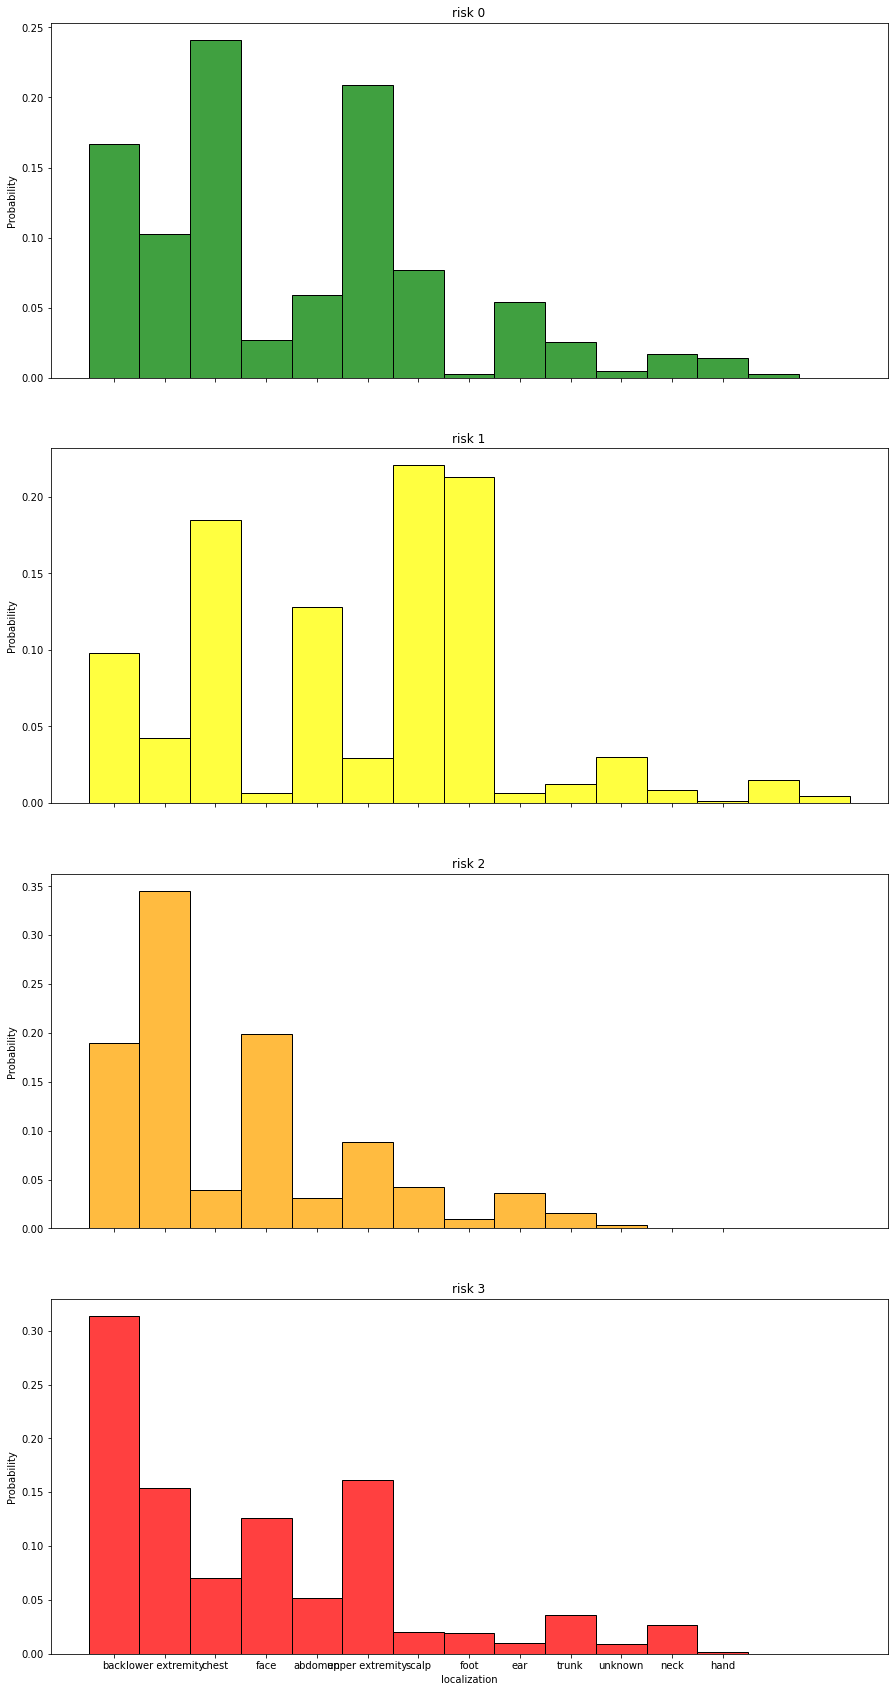

In [84]:
fig, axs = plt.subplots(4,1, figsize=(15,30), sharex=True)

sns.histplot(x='localization', data=df[df['risk'] == 0.0], color='green', stat='probability', ax=axs[0]).set_title('risk 0')
sns.histplot(x='localization', data=df[df['risk'] == 1.0], color='yellow', stat='probability', ax=axs[1]).set_title('risk 1')
sns.histplot(x='localization', data=df[df['risk'] == 2.0], color='orange', stat='probability', ax=axs[2]).set_title('risk 2')
sns.histplot(x='localization', data=df[df['risk'] == 3.0], color='red', stat='probability', ax=axs[3]).set_title('risk 3')

In [5]:
X = []

for i in tqdm(range(0, 10015)):
    file = df.iloc[i]['image_id']
    
    img = image.load_img('./Data/HAM10000_images/' + file + '.jpg', target_size= (150,200))
    img = image.img_to_array(img) / 255.0
    
    
    X.append(img)

100%|██████████| 10015/10015 [01:01<00:00, 162.65it/s]


In [6]:
X = np.array(X)

X.shape

(10015, 150, 200, 3)

In [7]:
risk = []

for ele in df['risk']:
    risk.append(tf.one_hot(int(ele), 4))
    
y = np.array(risk)
y.shape

(10015, 4)

In [29]:
ori_model = models.Sequential()
ori_model.add(layers.Conv2D(64, (3, 3), activation='tanh', input_shape=(150,200,3)))
ori_model.add(layers.BatchNormalization())
ori_model.add(layers.Activation(activations.elu))
ori_model.add(layers.MaxPooling2D(2,2))


ori_model.add(layers.Conv2D(32, (3, 3), activation='tanh'))
ori_model.add(layers.BatchNormalization())
ori_model.add(layers.Activation(activations.elu))
ori_model.add(layers.MaxPooling2D(2,2))


ori_model.add(layers.Conv2D(16, (3, 3), activation='tanh'))
ori_model.add(layers.BatchNormalization())
ori_model.add(layers.Activation(activations.elu))
ori_model.add(layers.MaxPooling2D(2,2))


ori_model.add(layers.Flatten(name="feature_output"))

ori_model.add(layers.Dense(1024, activation='relu'))
ori_model.add(layers.Dense(256, activation='relu'))
ori_model.add(layers.Dense(64, activation='relu'))
ori_model.add(layers.Dense(4))

In [12]:
ori_model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
ori_model.fit(X, y, epochs=25, validation_split=0.1, batch_size=16)

Train on 9013 samples, validate on 1002 samples
Epoch 1/10
9013/9013 [==============================] - 1395s 155ms/sample - loss: 0.8991 - accuracy: 0.6574 - val_loss: 1.8887 - val_accuracy: 0.2166
Epoch 2/10
9013/9013 [==============================] - 1399s 155ms/sample - loss: 0.7943 - accuracy: 0.6831 - val_loss: 7.8821 - val_accuracy: 0.6487
Epoch 3/10
9013/9013 [==============================] - 1506s 167ms/sample - loss: 0.7726 - accuracy: 0.6788 - val_loss: 0.8484 - val_accuracy: 0.6527
Epoch 4/10
9013/9013 [==============================] - 1506s 167ms/sample - loss: 0.7592 - accuracy: 0.6847 - val_loss: 2.2043 - val_accuracy: 0.6487
Epoch 5/10
9013/9013 [==============================] - 1505s 167ms/sample - loss: 0.7377 - accuracy: 0.6937 - val_loss: 4.0482 - val_accuracy: 0.6487
Epoch 6/10
9013/9013 [==============================] - 1505s 167ms/sample - loss: 0.7242 - accuracy: 0.7004 - val_loss: 1.0555 - val_accuracy: 0.6487
Epoch 7/10
9013/9013 [========================

In [33]:
ori_model.save('./models/feature')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/feature/assets


In [35]:
loaded_model = tf.keras.models.load_model("./models/feature")


feature_extractor = tf.keras.Model(
    inputs=loaded_model.inputs,
    outputs=loaded_model.get_layer(name="feature_output").output,
)

In [25]:
feature_vector = []

for i in tqdm(range(0, 10015)):
    sex = 0 if df.iloc[i]['sex'] == 'male' else 1
    age = df.iloc[i]['age']
    loc = df.iloc[i]['localization']
    
    feat = np.array([sex, age])
    
    if loc == 'abdomen':
        feat = np.concatenate((feat, tf.one_hot(0, 15)))
    elif loc == 'scalp':
        feat = np.concatenate((feat, tf.one_hot(1, 15)))
    elif loc == 'lower extremity':
        feat = np.concatenate((feat, tf.one_hot(2, 15)))
    elif loc == 'trunk':
        feat = np.concatenate((feat, tf.one_hot(3, 15)))
    elif loc == 'upper extremity':
        feat = np.concatenate((feat, tf.one_hot(4, 15)))
    elif loc == 'back':
        feat = np.concatenate((feat,tf.one_hot(5, 15)))
    elif loc == 'neck':
        feat = np.concatenate((feat,tf.one_hot(6, 15)))
    elif loc == 'face':
        feat = np.concatenate((feat,tf.one_hot(7, 15)))
    elif loc == 'chest':
        feat = np.concatenate((feat,tf.one_hot(8, 15)))
    elif loc == 'foot':
        feat = np.concatenate((feat,tf.one_hot(9, 15)))
    elif loc == 'ear':
        feat = np.concatenate((feat,tf.one_hot(10, 15)))
    elif loc == 'unknown':
        feat = np.concatenate((feat,tf.one_hot(11, 15)))
    elif loc == 'hand':
        feat = np.concatenate((feat,tf.one_hot(12, 15)))
    elif loc == 'acral':
        feat = np.concatenate((feat,tf.one_hot(13, 15)))
    elif loc == 'genital':
        feat = np.concatenate((feat,tf.one_hot(14, 15)))

    feature_vector.append(feat)

100%|██████████| 10015/10015 [00:06<00:00, 1610.32it/s]


In [26]:
feature_vector = np.array(feature_vector)

In [27]:
feature_vector.shape

(10015, 17)

In [ ]:
image_features = feature_extractor(X)

In [ ]:
X = []
for img_feat, feat in zip(image_features, feature_vector):
    X.append(np.concatenate((img_feat, feat)))

X = np.array(X)

In [ ]:
model = models.Sequential()

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4))

In [12]:
model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
model.fit(X, y, epochs=25, validation_split=0.1, batch_size=16)

Train on 9013 samples, validate on 1002 samples
Epoch 1/10
9013/9013 [==============================] - 1395s 155ms/sample - loss: 0.8991 - accuracy: 0.6574 - val_loss: 1.8887 - val_accuracy: 0.2166
Epoch 2/10
9013/9013 [==============================] - 1399s 155ms/sample - loss: 0.7943 - accuracy: 0.6831 - val_loss: 7.8821 - val_accuracy: 0.6487
Epoch 3/10
9013/9013 [==============================] - 1506s 167ms/sample - loss: 0.7726 - accuracy: 0.6788 - val_loss: 0.8484 - val_accuracy: 0.6527
Epoch 4/10
9013/9013 [==============================] - 1506s 167ms/sample - loss: 0.7592 - accuracy: 0.6847 - val_loss: 2.2043 - val_accuracy: 0.6487
Epoch 5/10
9013/9013 [==============================] - 1505s 167ms/sample - loss: 0.7377 - accuracy: 0.6937 - val_loss: 4.0482 - val_accuracy: 0.6487
Epoch 6/10
9013/9013 [==============================] - 1505s 167ms/sample - loss: 0.7242 - accuracy: 0.7004 - val_loss: 1.0555 - val_accuracy: 0.6487
Epoch 7/10
9013/9013 [========================

In [2]:
df = pd.read_csv('./data/HAM10000_Metadata')

In [3]:
df = df.sample(frac = 1).reset_index()

df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,1179,HAM_0003081,ISIC_0033860,df,consensus,45.0,male,abdomen,vidir_modern
1,3482,HAM_0004982,ISIC_0025192,nv,follow_up,35.0,male,upper extremity,vidir_molemax
2,8596,HAM_0006342,ISIC_0024425,nv,histo,40.0,female,face,rosendahl
3,2317,HAM_0000536,ISIC_0031844,mel,histo,45.0,female,lower extremity,rosendahl
4,4710,HAM_0000334,ISIC_0026860,nv,follow_up,35.0,female,abdomen,vidir_molemax


In [4]:
risk = []

for i in range(0, 10015):
    if df.iloc[i]['dx'] in ['bkl', 'df', 'vasc']:
        risk.append('no')
    elif df.iloc[i]['dx'] == 'nv':
        risk.append('lo')
    elif df.iloc[i]['dx'] == 'akiec':
        risk.append('md')
    elif df.iloc[i]['dx'] in ['mel', 'bcc']:
        risk.append('hi')
        
df['risk'] = risk

df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,risk
0,1179,HAM_0003081,ISIC_0033860,df,consensus,45.0,male,abdomen,vidir_modern,no
1,3482,HAM_0004982,ISIC_0025192,nv,follow_up,35.0,male,upper extremity,vidir_molemax,lo
2,8596,HAM_0006342,ISIC_0024425,nv,histo,40.0,female,face,rosendahl,lo
3,2317,HAM_0000536,ISIC_0031844,mel,histo,45.0,female,lower extremity,rosendahl,hi
4,4710,HAM_0000334,ISIC_0026860,nv,follow_up,35.0,female,abdomen,vidir_molemax,lo


In [5]:
df['image_id'] = df['image_id'].apply(lambda x: x + '.jpg')

df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,risk
0,1179,HAM_0003081,ISIC_0033860.jpg,df,consensus,45.0,male,abdomen,vidir_modern,no
1,3482,HAM_0004982,ISIC_0025192.jpg,nv,follow_up,35.0,male,upper extremity,vidir_molemax,lo
2,8596,HAM_0006342,ISIC_0024425.jpg,nv,histo,40.0,female,face,rosendahl,lo
3,2317,HAM_0000536,ISIC_0031844.jpg,mel,histo,45.0,female,lower extremity,rosendahl,hi
4,4710,HAM_0000334,ISIC_0026860.jpg,nv,follow_up,35.0,female,abdomen,vidir_molemax,lo


In [51]:
# VGG-16
VGG_load = VGG16(weights='imagenet')

model = models.Sequential()
model.add(VGG_load)
model.add(layers.Dense(4))

In [8]:
data_gen = ImageDataGenerator(
    rotation_range=90, 
    width_shift_range=0.2, 
    height_shift_range=0.2,
    horizontal_flip=True, preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
    vertical_flip=True, validation_split=0.1, zoom_range=0.3)

In [9]:
df['risk'].value_counts()

lo    6705
hi    1627
no    1356
md     327
Name: risk, dtype: int64

In [16]:
data_gen.flow_from_dataframe(df, directory='./data/HAM10000_images',
                                          x_col='image_id', y_col='risk', target_size=(224,224),
                                          subset='training').class_indices

Found 8012 validated image filenames belonging to 4 classes.


{'hi': 0, 'lo': 1, 'md': 2, 'no': 3}

In [17]:
data_gen.flow_from_dataframe(df, directory='./data/HAM10000_images',
                                          x_col='image_id', y_col='risk', target_size=(224,224),
                                          subset='validation').class_indices

Found 2003 validated image filenames belonging to 4 classes.


{'hi': 0, 'lo': 1, 'md': 2, 'no': 3}

In [41]:
class_weights = {'hi':1, 'lo':0.25, 'md':5, 'no':1}

In [43]:
sample_weights = []

for i in range(0, 10015):
    sample_weights.append(class_weights[df.iloc[i]['risk']])
    
df['weight'] = sample_weights

df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,risk,weight
0,1179,HAM_0003081,ISIC_0033860.jpg,df,consensus,45.0,male,abdomen,vidir_modern,no,1.00
1,3482,HAM_0004982,ISIC_0025192.jpg,nv,follow_up,35.0,male,upper extremity,vidir_molemax,lo,0.25
2,8596,HAM_0006342,ISIC_0024425.jpg,nv,histo,40.0,female,face,rosendahl,lo,0.25
3,2317,HAM_0000536,ISIC_0031844.jpg,mel,histo,45.0,female,lower extremity,rosendahl,hi,1.00
4,4710,HAM_0000334,ISIC_0026860.jpg,nv,follow_up,35.0,female,abdomen,vidir_molemax,lo,0.25


In [45]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])

model.fit(
    x=data_gen.flow_from_dataframe(df, directory='./data/HAM10000_images', weight_col='weight',
                                          x_col='image_id', y_col='risk', target_size=(224,224),
                                          subset='training'),
    validation_data=data_gen.flow_from_dataframe(df, directory='./data/HAM10000_images', weight_col='weight',
                                          x_col='image_id', y_col='risk', target_size=(224,224),
                                          subset='validation'),
    epochs=50)

Found 8012 validated image filenames belonging to 4 classes.
Found 2003 validated image filenames belonging to 4 classes.


KeyboardInterrupt: 

In [40]:
feature_vector = []

for i in tqdm(range(0, 10015)):
    sex = 0 if df.iloc[i]['sex'] == 'male' else 1
    age = df.iloc[i]['age']
    loc = df.iloc[i]['localization']
    
    feat = np.array([sex, age])
    
    if loc == 'abdomen':
        feat = np.concatenate((feat, tf.one_hot(0, 15)))
    elif loc == 'scalp':
        feat = np.concatenate((feat, tf.one_hot(1, 15)))
    elif loc == 'lower extremity':
        feat = np.concatenate((feat, tf.one_hot(2, 15)))
    elif loc == 'trunk':
        feat = np.concatenate((feat, tf.one_hot(3, 15)))
    elif loc == 'upper extremity':
        feat = np.concatenate((feat, tf.one_hot(4, 15)))
    elif loc == 'back':
        feat = np.concatenate((feat,tf.one_hot(5, 15)))
    elif loc == 'neck':
        feat = np.concatenate((feat,tf.one_hot(6, 15)))
    elif loc == 'face':
        feat = np.concatenate((feat,tf.one_hot(7, 15)))
    elif loc == 'chest':
        feat = np.concatenate((feat,tf.one_hot(8, 15)))
    elif loc == 'foot':
        feat = np.concatenate((feat,tf.one_hot(9, 15)))
    elif loc == 'ear':
        feat = np.concatenate((feat,tf.one_hot(10, 15)))
    elif loc == 'unknown':
        feat = np.concatenate((feat,tf.one_hot(11, 15)))
    elif loc == 'hand':
        feat = np.concatenate((feat,tf.one_hot(12, 15)))
    elif loc == 'acral':
        feat = np.concatenate((feat,tf.one_hot(13, 15)))
    elif loc == 'genital':
        feat = np.concatenate((feat,tf.one_hot(14, 15)))

    feature_vector.append(feat)
feature_vector = np.array(feature_vector)

feature_vector.shape

100%|██████████| 10015/10015 [00:06<00:00, 1620.45it/s]


(10015, 17)

In [39]:
feature_extractor = tf.keras.Model(
    inputs=VGG_load.inputs,
    outputs=VGG_load.layers[-4].output,
)

In [ ]:
preprocessed = []

for i in tqdm(range(0, 10015)):
    file = df.iloc[i]['image_id']
    feat_vec = feature_vector[i]    
    
    img = image.load_img('./Data/HAM10000_images/' + file, target_size= (224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    img_feat = feature_extractor(img)

    preprocessed.append(np.concatenate((img_feat, feat_vec)))
    
preprocessed = np.array(preprocessed)

In [46]:
ohr = []

for i in range(0, 10015):
    risk = df.iloc[i]['risk']
    
    if risk == 'no':
        ohr.append(tf.one_hot(0, 4))
    elif risk == 'lo':
        ohr.append(tf.one_hot(1, 4))
    elif risk == 'md':
        ohr.append(tf.one_hot(2, 4))
    elif risk == 'hi':
        ohr.append(tf.one_hot(3, 4))
        
ohr = np.array(ohr)

ohr.shape

(10015, 4)

In [47]:
new_model = models.Sequential()
new_model.add(layers.Dense(4096, activation='relu'))
new_model.add(layers.Dense(2048, activation='relu'))
new_model.add(layers.Dense(512, activation='relu'))
new_model.add(layers.Dense(128, activation='relu'))
new_model.add(layers.Dense(4))

In [49]:
new_model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
new_model.fit(preprocessed, ohr, sample_weight=np.array(df['weight']), epochs=10, validation_split=0.1)

NameError: name 'preprocessed' is not defined